In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the Rastrigin function
def rastrigin(x): # min -5.12 max 5.12
    n = len(x)
    return 10*n + sum([xi**2 - 10*np.cos(2*np.pi*xi) for xi in x])

def rosenbrock(x): # -2.048 2.048
    return (1-x[0])**2 + 100*(x[1]-x[0]*2)**2

def himmelblau(x): # min -3 max 3
    return (x[0]**2+x[1]-11)**2 + (x[0]+x[1]-7)**2

def griewank(x):
    x = np.array(x)
    return (x[0]**2 + x[1]**2)/4000 - np.cos(x[0]) * np.cos(x[1]/np.sqrt(2)) + 1

def metrics(fitness_list):
    optimal_value = 0
    tolerance = 1e-6
    count_optimal = np.sum(np.abs(fitness_list - optimal_value) <= tolerance)

    mean_val = np.mean(fitness_list)
    median_val = np.median(fitness_list)
    std_val = np.std(fitness_list)

    return count_optimal, mean_val, median_val, std_val


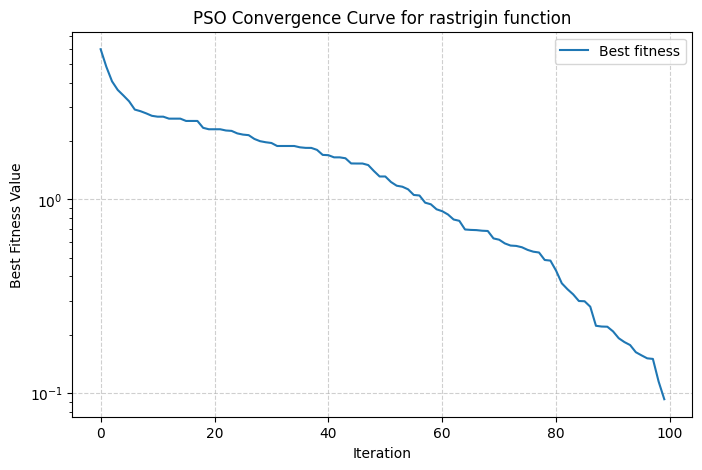

<Figure size 640x480 with 0 Axes>

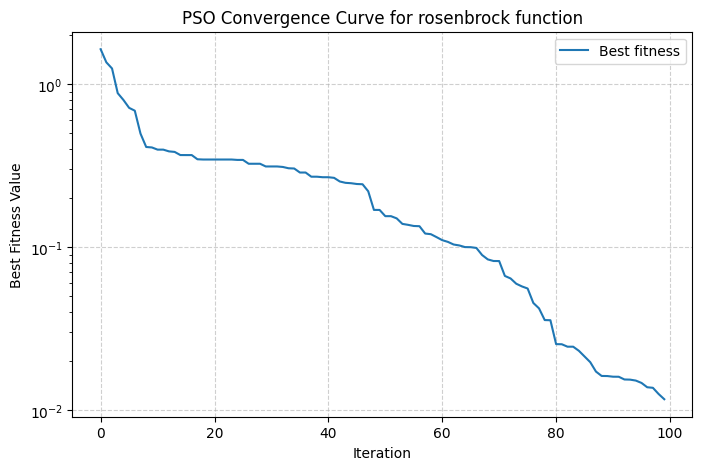

<Figure size 640x480 with 0 Axes>

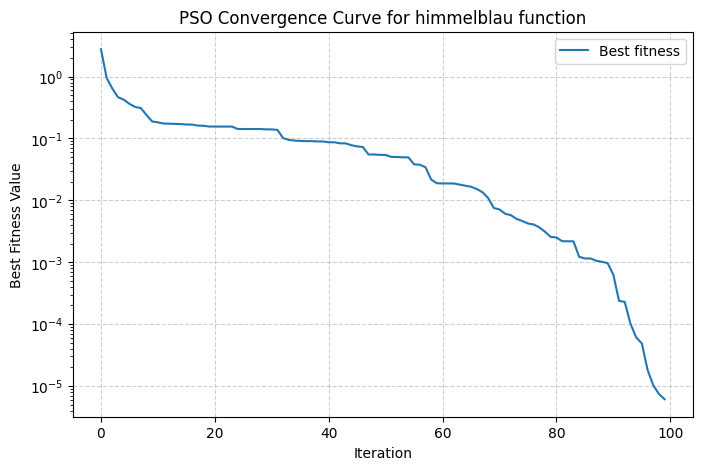

<Figure size 640x480 with 0 Axes>

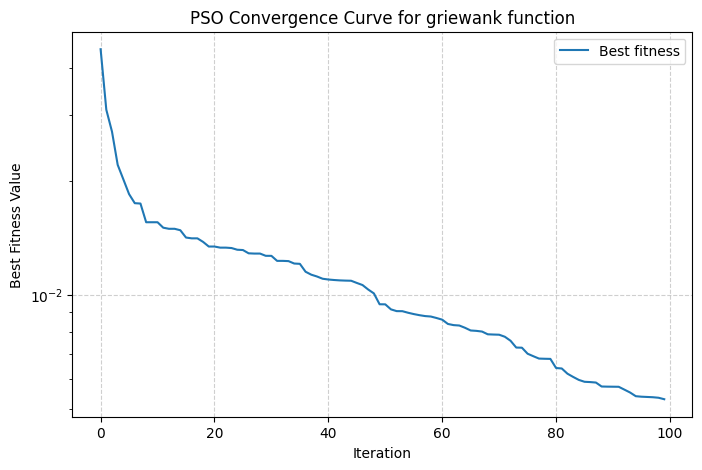

<Figure size 640x480 with 0 Axes>

In [31]:
# Define the PSO algorithm
def pso(cost_func, dim=2, bounds = (-5,5), num_particles=30, max_iter=100, wmin = 0.4, wmax = 0.9, c1=2, c2=2):
    # Initialize particles and velocities
    particles = np.random.uniform(bounds[0], bounds[1], (num_particles, dim))
    velocities = np.zeros((num_particles, dim))

    # Initialize the best positions and fitness values
    best_positions = np.copy(particles)
    best_fitness = np.array([cost_func(p) for p in particles])
    swarm_best_position = best_positions[np.argmin(best_fitness)]
    swarm_best_fitness = np.min(best_fitness)
    best_fitness_list = []
    # Iterate through the specified number of iterations, updating the velocity and position of each particle at each iteration
    for i in range(max_iter):
        # Update velocities
        r1 = np.random.uniform(0, 1, (num_particles, dim))
        r2 = np.random.uniform(0, 1, (num_particles, dim))
        w = wmax - ((wmax-wmin)/max_iter)*i # linear decreasing inertia
        velocities = w * velocities + c1 * r1 * (best_positions - particles) + c2 * r2 * (swarm_best_position - particles)

        # Update positions
        particles += velocities

        # Evaluate fitness of each particle
        fitness_values = np.array([cost_func(p) for p in particles])

        # Update best positions and fitness values
        improved_indices = np.where(fitness_values < best_fitness)
        best_positions[improved_indices] = particles[improved_indices]
        best_fitness[improved_indices] = fitness_values[improved_indices]
        if np.min(fitness_values) < swarm_best_fitness:
            swarm_best_position = particles[np.argmin(fitness_values)]
            swarm_best_fitness = np.min(fitness_values)
        best_fitness_list.append(swarm_best_fitness)

    # Return the best solution found by the PSO algorithm
    return swarm_best_position, swarm_best_fitness, best_fitness_list


# Define the dimensions of the problem
dim = 2

n_runs = 31

functions = {rastrigin : (-5.12, 5.12), rosenbrock: (-2.048, 2.048), himmelblau: (-3,3), griewank : (-5,5)}

for function in functions.keys():
    best_values = []
    best_fitness_list_list = [] # save best values of each run for the convergence plot
    for i in range(n_runs):
        # Run the PSO algorithm on the Rastrigin function
        
        solution, fitness, fitness_list = pso(function, dim=dim, bounds = functions[function])
        best_values.append(fitness)
        #print(function.__name__, solution)
        best_fitness_list_list.append(fitness_list)
    fitness_array = np.array(best_fitness_list_list)
    mean_for_graph = np.mean(fitness_array, axis=0)
    best_values = np.array(best_values)
    count, mean_val, median_val, std_val = metrics(best_values)

    results = {"Count of reached optimal value" : count,
               "Mean" : mean_val,
               "Median": median_val,
               "Standard deviation": std_val}
    
    results_df = pd.DataFrame(results, index = [0])

    results_df.to_csv(f"PSO_{function.__name__}_metrics.csv", index = False)

    best_values_df = pd.DataFrame(best_values)
    best_values_df.to_csv(f"PSO_{function.__name__}best_fitness.csv", index = False)

    plt.figure(figsize=(8,5))
    plt.plot(mean_for_graph, label='Best fitness')
    plt.title(f"PSO Convergence Curve for {function.__name__} function")
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness Value")
    plt.yscale("log")  # log scale is common for minimization plots
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.savefig(f"PSO_{function.__name__}_convergence.png")
    plt.show()
    
    plt.clf()
    
    # # Create a meshgrid for visualization
    # x = np.linspace(functions[function][0], functions[function][1], 100)
    # y = np.linspace(-5.12, 5.12, 100)
    # X, Y = np.meshgrid(x, y)
    # Z = function([X, Y]) 

    # # Create a 3D plot of the function
    # fig = plt.figure(figsize=(4,4))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.plot_surface(X, Y, Z, cmap='viridis')
    # plt.title(f"3D graph of the {function.__name__} function")
    # ax.set_xlabel('x')
    # ax.set_ylabel('y')
    # ax.set_zlabel('z')
    # fig.tight_layout()
    # plt.savefig(f"{function.__name__}_graph.png")
    # plt.show()
    

# # Plot the solution found by the PSO algorithm
# ax.scatter(solution[0], solution[1], fitness, color='red')
# plt.show()

## Genetic algorithm

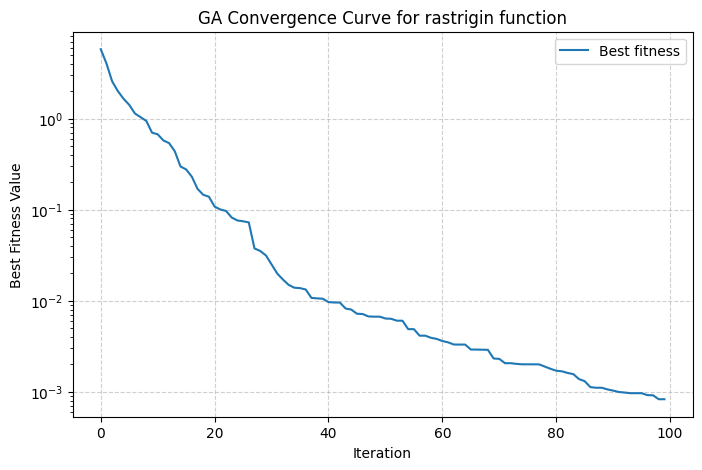

<Figure size 640x480 with 0 Axes>

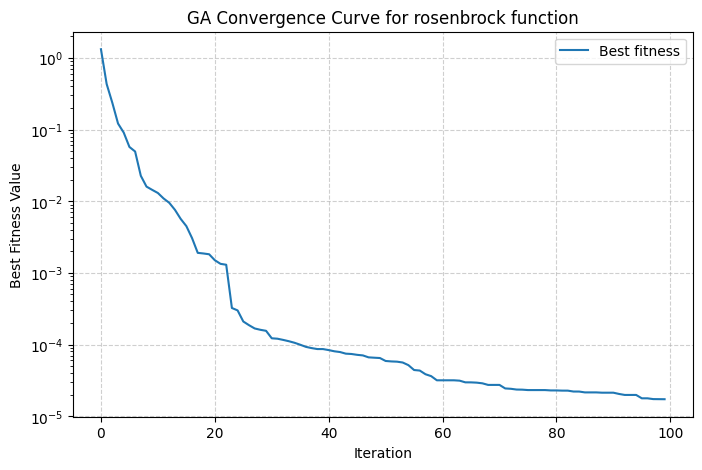

<Figure size 640x480 with 0 Axes>

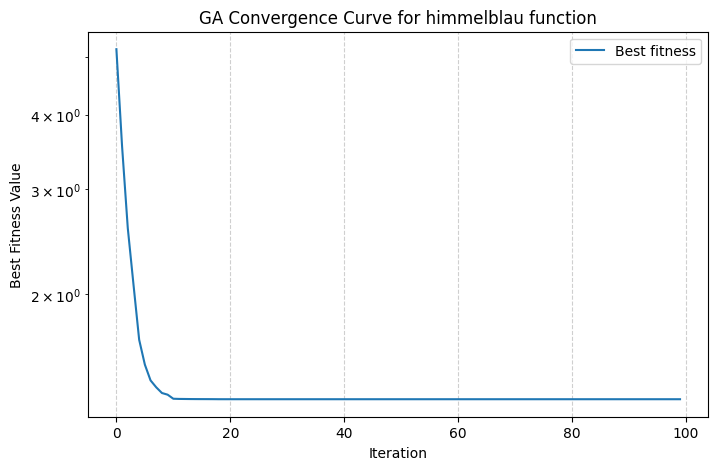

<Figure size 640x480 with 0 Axes>

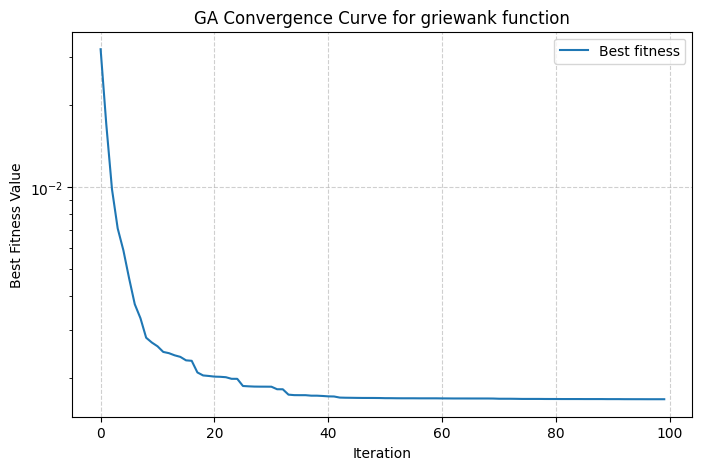

<Figure size 640x480 with 0 Axes>

In [21]:
# Real number encoding

"""
variables:
pop -> population
"""

def init_population(pop_size, dim, low, high, rng):
    return rng.uniform(low, high, size=(pop_size, dim))

# crossover: SBX (Simulated Binary Crossover)
def crossover(p1, p2, eta_c, rng):
  u = rng.random(len(p1))
  beta = np.where(u <= 0.5,
                  (2.0*u)**(1.0/(eta_c+1.0)),
                  (1.0/(2.0*(1.0-u)))**(1.0/(eta_c+1.0)))
  c1 = 0.5*((1+beta)*p1 + (1-beta)*p2)
  c2 = 0.5*((1-beta)*p1 + (1+beta)*p2)
  return c1, c2

# mutation: Parameter-based mutation (PM)
def mutate(x, low, high, pm, rng, eta_m=20):

  x = np.asarray(x, dtype=float)
  low  = np.asarray(low,  dtype=float) if np.ndim(low)  else float(low)
  high = np.asarray(high, dtype=float) if np.ndim(high) else float(high)

  x = np.clip(x, low, high)
  x_new = x.copy()

  #mask of genes
  m = rng.random(x.shape) < pm

  eta_p1 = float(eta_m) + 1.0
  eps_w = 1e-12

  for idx in np.where(m)[0]:
    yl = low[idx]  if np.ndim(low)  else low
    yu = high[idx] if np.ndim(high) else high
    w  = yu - yl
    if w <= eps_w:
      continue

    u = float(rng.random())

    xi = float(x_new[idx])
    delta = min(xi - yl, yu - xi) / w
    delta = float(np.clip(delta, 0.0, 1.0))

    base = (1.0 - delta) ** eta_p1
    if u <= 0.5:
        dq = (2.0 * u + (1.0 - 2.0 * u) * base) ** (1.0 / eta_p1) - 1.0
    else:
        dq = 1.0 - (2.0 * (1.0 - u) + 2.0 * (u - 0.5) * base) ** (1.0 / eta_p1)

    x_new[idx] = np.clip(xi + dq * w, yl, yu)

  return x_new

# selection: binary tournament (deterministic)
def selection(fitnesses, rng):
    i, j = rng.integers(0, len(fitnesses), size=2)
    return i if fitnesses[i] <= fitnesses[j] else j

# evaluate population
def evaluate(pop, fit_fn):
    return np.array([fit_fn(ind) for ind in pop])



# Real numbers
# Parameters
runs = 31
dim = 2


pop_size = 100
gens = 100
eta_c = 15
pm = 1.0/dim
eta_m = 20

# save

rng = np.random.default_rng(123)

functions = {rastrigin : (-5.12, 5.12), rosenbrock: (-2.048, 2.048), himmelblau: (-3,3), griewank : (-5,5)}

    
for function in functions.keys():
    low = np.array([functions[function][0], functions[function][0]])
    high = np.array([functions[function][1], functions[function][1]])
    all_best = []
    best_fitness_list_list = []
    for r in range(runs):
      pop = init_population(pop_size, dim, low, high, rng)
      best_fitness_list = []

      for g in range(gens):
          fits = evaluate(pop, function)

          elite_idx = np.argmin(fits)
          elite = pop[elite_idx].copy()
          elite_fit = fits[elite_idx]

          best_fitness_list.append(elite_fit)

          new_pop = [elite]

          while len(new_pop) < pop_size:
              # selection
              i = selection(fits, rng)
              j = selection(fits, rng)
              p1, p2 = pop[i], pop[j]

              # crossover
              c1, c2 = crossover(p1, p2, eta_c, rng)

              # mutation
              c1 = mutate(c1, low, high, pm, rng, eta_m=eta_m)
              c2 = mutate(c2, low, high, pm, rng, eta_m=eta_m)

              new_pop.extend([c1, c2])

          pop = np.array(new_pop[:pop_size])

      final_fits = evaluate(pop, function)
      best_idx = np.argmin(final_fits)
      best_x = pop[best_idx]
      best_f = final_fits[best_idx]

      best_fitness_list_list.append(best_fitness_list)


      all_best.append(best_f)
    fitness_array = np.array(best_fitness_list_list)
    mean_for_graph = np.mean(fitness_array, axis=0)
    all_best = np.array(all_best)
    count, mean_val, median_val, std_val = metrics(all_best)
      
    results = {"Count of reached optimal value" : count,
               "Mean" : mean_val,
               "Median": median_val,
               "Standard deviation": std_val}
    
    results_df = pd.DataFrame(results, index = [0])

    results_df.to_csv(f"GA_{function.__name__}_metrics.csv")

    best_values_df = pd.DataFrame(all_best)
    best_values_df.to_csv(f"GA_{function.__name__}best_fitness.csv", index=False)

    plt.figure(figsize=(8,5))
    plt.plot(mean_for_graph, label='Best fitness')
    plt.title(f"GA Convergence Curve for {function.__name__} function")
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness Value")
    plt.yscale("log")  # log scale is common for minimization plots
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.savefig(f"GA_{function.__name__}_convergence.png")
    plt.show()
    
    plt.clf()

Wilcoxon-Test

In [34]:
from scipy.stats import ranksums
functions = [rastrigin, rosenbrock, himmelblau, griewank]
for f in functions:

    res_ga = pd.read_csv(f"GA_{f.__name__}best_fitness.csv")
    res_pso = pd.read_csv(f"PSO_{f.__name__}best_fitness.csv")
    stat, p = ranksums(res_ga, res_pso)
    print(f.__name__)
    print(stat, p)
    if p < 0.05:
        print("=> Significant difference")
    else:
        print("=> No significant difference")

rastrigin
[0.75320369] [0.45132752]
=> No significant difference
rosenbrock
[-6.24384738] [4.26936606e-10]
=> Significant difference
himmelblau
[6.7647546] [1.33535344e-11]
=> Significant difference
griewank
[-2.52710395] [0.01150075]
=> Significant difference
